In [2]:
import pandas as pd
import os.path
import numpy as np
import glob
from matplotlib import pyplot as plt
import seaborn as sns
#import pingouin as pg
import openpyxl
import re
class StopCell(Exception): # a custom (mute) exception to exit cells programmatically ("raise StopCell")
    def _render_traceback_(self):
        pass

# Analysis Tactile Revcor
&copy; Céline Vanney, Etienne Louyot, JJ Aucouturier, PH Cornuault, Luc Carpentier


## Behavioural data

### Load Behavioural data

In [3]:
for file in glob.glob("./data/behaviour/*results*.csv"):
    print(file)

./data/behaviour\221110_08.22_results_subj6_soft.csv
./data/behaviour\221110_10.41_results_subj7_soft.csv
./data/behaviour\221110_14.16_results_subj8_soft.csv
./data/behaviour\221115_10.24_results_subj9_rug.csv
./data/behaviour\221116_15.47_results_subj10_rug.csv
./data/behaviour\221117_10.16_results_subj11_soft.csv
./data/behaviour\221117_15.45_results_subj12_rug.csv
./data/behaviour\221118_10.35_results_subj13_rug.csv
./data/behaviour\221121_08.55_results_subj14_soft.csv
./data/behaviour\221121_15.48_results_subj15_soft.csv
./data/behaviour\221122_08.42_results_subj16_soft.csv
./data/behaviour\221122_10.23_results_subj17_soft.csv
./data/behaviour\221122_14.05_results_subj18_soft.csv
./data/behaviour\221122_15.52_results_subj19_soft.csv
./data/behaviour\221123_10.28_results_subj20_soft.csv
./data/behaviour\221123_13.37_results_subj21_soft.csv
./data/behaviour\221124_13.36_results_subj22_soft.csv
./data/behaviour\221124_15.54_results_subj23_soft.csv
./data/behaviour\221125_09.06_result

#### Fix condition field & filename

Result files from participant 7 onwards include a `condition` field, and have their condition in the filename. Correct this for earlier participants. 

In [4]:
if True: raise StopCell

conditions = {'1':'rug', '2':'soft', '3':'soft',
             '4':'soft', '5':'soft','6':'soft'}

for participant in [6]: 
    
    # get participant file
    file = glob.glob("./data/behaviour/*results_subj%d*.csv"%participant)[0]
    
    # add condition in pandas
    condition = conditions[str(participant)]
    participant_data = pd.read_csv(file)
    participant_data['condition'] = condition
    
    # and save as new csv file with updated filename
    name, ext = os.path.splitext(os.path.basename(file))
    updated_filename = './data/behaviour/' + name + '_'+ condition + ext
    participant_data.to_csv(updated_filename,index=False)

#### Load all data

In [7]:
data_files = glob.glob("./data/behaviour/*_results_*.csv")
print("got %d behavioural files"%len(data_files))
data_df = pd.DataFrame()
for data_file in data_files:
    participant_data_df = pd.read_csv(data_file, sep = ',', decimal='.', header='infer')
    data_df = pd.concat([data_df, participant_data_df], ignore_index=True)
print('dataframe has %d subjects'%data_df.subj.nunique())

got 22 behavioural files
dataframe has 22 subjects


In [8]:
data_df

,subj,trial,block,practice,condition,sex,age,date,data_file,texture_id,stim_order,diameter,opening,spacing,response,rt
0,6,0,0,True,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block0_trial0_...,E019,0,440.0,140.0,580.0,True,19.445
1,6,0,0,True,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block0_trial0_...,E027,1,170.0,80.0,250.0,False,19.445
2,6,1,0,True,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block0_trial1_...,E068,0,20.0,80.0,100.0,True,12.811
3,6,1,0,True,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block0_trial1_...,E079(S41),1,50.0,110.0,160.0,False,12.811
4,6,2,0,True,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block0_trial2_...,E075(S42),0,20.0,20.0,40.0,True,13.262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4615,27,22,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E078(S45),1,80.0,110.0,190.0,False,8.466
4616,27,23,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E038,0,110.0,80.0,190.0,True,7.617
4617,27,23,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E076(S43),1,50.0,50.0,100.0,False,7.617
4618,27,24,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E044,0,170.0,140.0,310.0,True,7.534


In [9]:
data_df.groupby(['condition','sex']).subj.unique()

condition  sex
rug        f                                      [9, 10, 12]
           m                                     [13, 26, 27]
soft       f      [6, 11, 14, 15, 16, 18, 21, 22, 23, 24, 25]
           m                               [7, 8, 17, 19, 20]
Name: subj, dtype: object

In [10]:
print("%d textures différentes utilisées"%data_df.texture_id.nunique())

84 textures différentes utilisées


##### Remove skipped blocks

<AxesSubplot:xlabel='subj', ylabel='trial'>

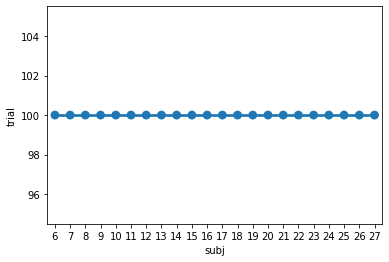

In [11]:
# all subjects have 100 trials
d=data_df[data_df.practice==False].groupby(['subj']).trial.count()/2
sns.pointplot(data=d.reset_index(), x='subj',y='trial')

In [12]:
# remove practice block
data_df = data_df[data_df.block.isin([1,2,3,4])]
# data_df = data_df[data_df.practice==False]

In [13]:
data_df.to_csv('data/behaviour/all_data.csv')

##### Number of different textures

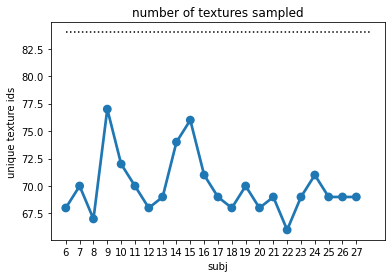

In [14]:
sns.pointplot(data=data_df.groupby('subj', as_index=False).texture_id.nunique(),
              x='subj',y='texture_id')
plt.title('number of textures sampled')
plt.ylabel('unique texture ids')

plt.plot([0,22],[data_df.texture_id.nunique(),data_df.texture_id.nunique()],'k:')


## Load summary meca data

<mark> todo: </mark> faire le même travail que ci-dessus avec les données de meca/summary
- loader les .xls avec read_excel
- concatener les différentes df dans une seule df (2 lignes par trials)
- remettre les mêmes noms de champs que dans all_data.csv (sub, block, trial)
- noms de colonne simples, en format snake_case (lower case with underscores)
- faire des sanity checks avec des groupby (combien de trials par subj, etc.)
- sauver en csv dans meca/summary/all_summary_data.csv

Join les 2 dataframe: pour chaque trial/surface dans behaviour, rajouter les colonnes de summary meca qui correspondent (`behaviour_df.join(summary_meca_df, on=['subj','block','trial','texture'])`)


### Load all data

In [6]:
data_summary = glob.glob("./data/meca/summary/*.xlsx")    
print("got %d summary files"%len(data_summary))
data_df_summary = pd.DataFrame()
for data_sum in data_summary:
    participant_data_summary = pd.read_excel(data_sum,engine="openpyxl")
    data_df_summary = pd.concat([data_df_summary, participant_data_summary], ignore_index=True)
print('dataframe has %d subjects'%data_df_summary.Subject.nunique())

got 9 summary files
dataframe has 23 subjects


In [15]:
data_df_summary


,Date (YYMMDD),Hour [h],Minute [min],Subject,Block,Trial,Texture,Start [s],End [s],Sliding distance [mm],V mean [mm/s],Fn mean [N],Fn std [N],Ft mean [N],Ft std [N],COF mean,COF std,RMS Accelero [m/s²]
0,221122,8,42,16,1,0,1,6.2692,6.8198,37.134524,67.936736,0.244839,0.081262,0.359014,0.075783,1.523927,0.218087,3.381203
1,221122,8,42,16,1,0,2,9.6768,10.3696,37.555220,53.228448,0.354724,0.038919,0.369661,0.026887,1.058695,0.168599,2.619718
2,221122,8,42,16,1,1,1,4.5892,5.2442,32.208557,48.929251,0.510734,0.031468,0.155038,0.012838,0.303306,0.011597,1.254451
3,221122,8,42,16,1,1,2,8.3478,9.2876,35.683789,38.321365,0.378196,0.023547,0.295779,0.043984,0.782811,0.112092,2.044252
4,221122,8,42,16,1,2,1,3.6212,4.4848,35.701824,41.388307,0.464945,0.025050,0.176368,0.016045,0.378981,0.022465,1.067344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4196,221125,17,18,27,4,22,2,4.7956,5.1706,35.853592,94.943428,1.574174,0.185896,0.564810,0.082925,0.357536,0.012494,6.140435
4197,221125,17,18,27,4,23,1,2.9734,3.5476,40.110299,73.018695,1.606961,0.068391,0.926973,0.076240,0.576235,0.029874,2.816130
4198,221125,17,18,27,4,23,2,5.0852,5.5312,35.825132,85.074553,1.676902,0.030933,0.750410,0.051388,0.447519,0.030270,1.416022
4199,221125,17,18,27,4,24,1,2.6174,3.2676,39.566893,60.739483,1.769655,0.085260,1.102541,0.186779,0.621689,0.096977,4.945476


### Convert columns names to snake_case

In [16]:
data_df_summary.rename(columns=lambda x: x[0].lower() + x.strip().lower().replace(' ', '_').title()[1:].lower(),inplace=True)  # snake_case
data_df_summary.rename(columns=lambda x: re.sub(r'[^a-z0-9_]', '', x.strip().lower().replace(' ', '_')), inplace=True)

In [17]:
data_df_summary.rename(columns={'subject': 'subj'},inplace=True)

### Sanity checks

<AxesSubplot:xlabel='subj', ylabel='trial'>

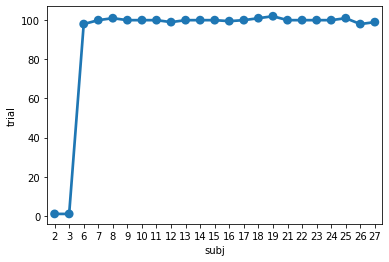

In [18]:
# Trials by subject
d=data_df_summary.groupby(['subj']).trial.count()/2
sns.pointplot(data=d.reset_index(), x='subj',y='trial')

#### Remove subjects with not many trials

In [19]:
min_trials = 96  # choix arbitraire proche de 100 
filter = data_df_summary.groupby(['subj']).trial.count()/2 
reliable_subjects= filter[filter > min_trials].index   # get subjects who have more tha min_trials
filtered_df = data_df_summary[data_df_summary['subj'].isin(reliable_subjects)]   # another dataset with reliable_subjects only

<AxesSubplot:xlabel='subj', ylabel='trial'>

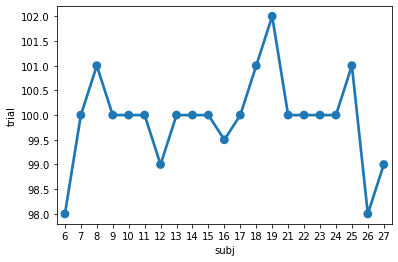

In [20]:
d=filtered_df.groupby(['subj']).trial.count()/2
sns.pointplot(data=d.reset_index(), x='subj',y='trial')

### Find duplicates

In [21]:
a = filtered_df.groupby(['subj','block','trial','texture']).subj.count()
a[a>1]

subj  block  trial  texture
6     2      9      1          2
                    2          2
7     1      19     1          2
                    2          2
8     3      13     1          2
                    2          2
15    2      19     1          2
                    2          2
16    2      14     1          2
                    2          2
17    1      18     1          2
                    2          2
      4      3      1          2
                    2          2
18    4      12     1          2
                    2          2
19    2      11     1          2
                    2          2
             22     1          2
                    2          2
21    1      18     1          2
                    2          2
22    1      11     1          2
                    2          2
25    2      0      1          2
                    2          2
             7      1          2
                    2          2
27    1      4      1          3
               

In [22]:
a = filtered_df.groupby(['subj','block','trial']).subj.count()
a[a>2]

subj  block  trial
6     2      9        4
7     1      19       4
8     3      13       4
15    2      19       4
16    2      14       4
17    1      18       4
      4      3        4
18    4      12       4
19    2      11       4
             22       4
21    1      18       4
22    1      11       4
25    2      0        4
             7        4
27    1      4        6
      3      4        4
Name: subj, dtype: int64

In [23]:
A = np.zeros((a[a>2].shape[0],3))
for i in range(a[a>2].shape[0]) :
    A[i] = a[a>2].index[i][0:3]
A

array([[ 6.,  2.,  9.],
       [ 7.,  1., 19.],
       [ 8.,  3., 13.],
       [15.,  2., 19.],
       [16.,  2., 14.],
       [17.,  1., 18.],
       [17.,  4.,  3.],
       [18.,  4., 12.],
       [19.,  2., 11.],
       [19.,  2., 22.],
       [21.,  1., 18.],
       [22.,  1., 11.],
       [25.,  2.,  0.],
       [25.,  2.,  7.],
       [27.,  1.,  4.],
       [27.,  3.,  4.]])

In [24]:
C = []
df_duplicates = pd.DataFrame()
for i in range(len(A)) :
    f = filtered_df[['subj','block','trial']] == A[i]   # f takes rows where subj block trial is equal to one of the values in B
    g = (f['subj'] == True ) & (f['block'] == True ) & (f['trial'] == True )  # 
    df_duplicates = pd.concat([df_duplicates,filtered_df[g]],ignore_index=True)
    C.extend(filtered_df[g].index.tolist())
C

[2859,
 2860,
 2905,
 2906,
 1441,
 1442,
 1443,
 1444,
 1731,
 1732,
 1733,
 1734,
 3097,
 3098,
 3099,
 3100,
 63,
 64,
 187,
 188,
 235,
 236,
 237,
 238,
 355,
 356,
 359,
 360,
 573,
 574,
 575,
 576,
 673,
 674,
 675,
 676,
 697,
 698,
 699,
 700,
 841,
 842,
 843,
 844,
 3023,
 3024,
 3223,
 3224,
 3655,
 3656,
 3657,
 3658,
 3671,
 3672,
 3771,
 3772,
 4011,
 4012,
 4013,
 4014,
 4059,
 4060,
 4107,
 4108,
 4109,
 4110]

In [25]:
df_duplicates

,date_yymmdd,hour_h,minute_min,subj,block,trial,texture,start_s,end_s,sliding_distance_mm,v_mean_mms,fn_mean_n,fn_std_n,ft_mean_n,ft_std_n,cof_mean,cof_std,rms_accelero_ms
0,221110,8,22,6,2,9,1,3.3526,4.9052,40.001157,26.310347,0.622010,0.043666,0.216880,0.019597,0.348312,0.012872,0.466223
1,221110,8,22,6,2,9,2,7.2442,8.5730,37.747892,30.712383,0.600878,0.046126,0.353949,0.036635,0.590088,0.057548,1.212777
2,221110,8,22,6,2,9,1,3.2510,4.9324,43.037827,26.142409,0.621583,0.046004,0.214720,0.021871,0.344863,0.014985,0.463103
3,221110,8,22,6,2,9,2,7.1968,8.5458,39.900249,30.149889,0.605730,0.047075,0.350097,0.041271,0.578181,0.058439,1.184577
4,221110,10,41,7,1,19,1,2.2916,3.1378,32.992349,41.864933,0.101238,0.026084,0.312260,0.060080,3.175598,0.560356,2.652215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,221125,17,18,27,1,4,2,6.3856,6.9286,42.061268,84.261083,1.182514,0.053128,0.550364,0.047463,0.464614,0.022094,1.816245
62,221125,17,18,27,3,4,1,3.0672,3.7506,37.728232,58.474466,2.532201,0.131307,1.114372,0.088322,0.439600,0.017786,1.591668
63,221125,17,18,27,3,4,2,5.7412,6.4246,41.891762,62.074603,2.882544,0.323801,0.933753,0.091300,0.324563,0.007151,4.633162
64,221125,17,18,27,3,4,1,3.1214,3.7290,34.732522,59.256924,2.553592,0.114949,1.125090,0.074682,0.440317,0.015797,1.591580


#### Garder les valeurs moyennes pour les doublons 

In [26]:
subset_cols = ['subj', 'block','trial','texture']
n = df_duplicates[df_duplicates.duplicated(subset=subset_cols, keep=False)]

v_moyennes = n.groupby(subset_cols)['v_mean_mms'].transform('mean')
fn_moyennes = n.groupby(subset_cols)['fn_mean_n'].transform('mean')
fn_std_moyennes = n.groupby(subset_cols)['fn_std_n'].transform('mean')
ft_moyennes = n.groupby(subset_cols)['ft_mean_n'].transform('mean')
ft_std_moyennes = n.groupby(subset_cols)['ft_std_n'].transform('mean')
cof_mean_moyennes = n.groupby(subset_cols)['cof_mean'].transform('mean')
cof_std_moyennes = n.groupby(subset_cols)['cof_std'].transform('mean')
rms_accelero_moyennes = n.groupby(subset_cols)['rms_accelero_ms'].transform('mean')

n = n.copy()

n['moyenne_vitesse'] = v_moyennes
n['moyenne_fn'] = fn_moyennes
n['moyenne_fn_std'] = fn_std_moyennes
n['moyenne_ft'] = ft_moyennes
n['moyenne_ft_std'] = ft_std_moyennes
n['moyenne_cof'] = cof_mean_moyennes
n['moyenne_cof_std'] = cof_std_moyennes
n['moyenne_rms'] = rms_accelero_moyennes


n['original_index'] = C   # column added for original_indexes of each row 
n.set_index("original_index",inplace=True)

duplicates = n[n.duplicated(subset=subset_cols, keep='first')]
#duplicates



In [27]:
duplicates['v_mean_mms'] = duplicates['moyenne_vitesse']
duplicates['fn_mean_n'] = duplicates['moyenne_fn']
duplicates['fn_std_n'] = duplicates['moyenne_fn_std']
duplicates['ft_mean_n'] = duplicates['moyenne_ft']
duplicates['ft_std_n'] = duplicates['moyenne_ft_std']
duplicates['cof_mean'] = duplicates['moyenne_cof']
duplicates['cof_std'] = duplicates['moyenne_cof_std']
duplicates['rms_accelero_ms'] = duplicates['moyenne_rms']


duplicates.drop(columns='moyenne_vitesse',inplace=True)
duplicates.drop(columns='moyenne_fn',inplace=True)
duplicates.drop(columns='moyenne_fn_std',inplace=True)
duplicates.drop(columns='moyenne_ft',inplace=True)
duplicates.drop(columns='moyenne_ft_std',inplace=True)
duplicates.drop(columns='moyenne_cof',inplace=True)
duplicates.drop(columns='moyenne_cof_std',inplace=True)
duplicates.drop(columns='moyenne_rms',inplace=True)


duplicates

<ipython-input-27-5b0daf000fcf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duplicates['v_mean_mms'] = duplicates['moyenne_vitesse']
<ipython-input-27-5b0daf000fcf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duplicates['fn_mean_n'] = duplicates['moyenne_fn']
<ipython-input-27-5b0daf000fcf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

,date_yymmdd,hour_h,minute_min,subj,block,trial,texture,start_s,end_s,sliding_distance_mm,v_mean_mms,fn_mean_n,fn_std_n,ft_mean_n,ft_std_n,cof_mean,cof_std,rms_accelero_ms
original_index,,,,,,,,,,,,,,,,,,
2905,221110,8,22,6,2,9,1,3.2510,4.9324,43.037827,26.226378,0.621797,0.044835,0.215800,0.020734,0.346587,0.013928,0.464663
2906,221110,8,22,6,2,9,2,7.1968,8.5458,39.900249,30.431136,0.603304,0.046600,0.352023,0.038953,0.584134,0.057994,1.198677
1443,221110,10,41,7,1,19,1,2.3078,3.1432,25.062685,41.951513,0.101547,0.026092,0.313148,0.059896,3.174782,0.558247,2.659617
1444,221110,10,41,7,1,19,2,5.9526,6.6252,30.510881,52.509730,0.067574,0.015653,0.181353,0.030545,2.774961,0.558039,2.375272
1733,221110,14,16,8,3,13,1,1.4154,1.8424,23.366494,58.175755,0.153862,0.025719,0.069178,0.006445,0.458190,0.063551,0.523803
1734,221110,14,16,8,3,13,2,4.5034,4.8730,29.505406,80.965874,0.109117,0.017255,0.076848,0.010333,0.709883,0.067115,0.544734
3099,221121,15,48,15,2,19,1,3.2066,4.2072,40.235965,41.743241,0.487055,0.034362,0.156091,0.008332,0.321450,0.020661,0.651874
3100,221121,15,48,15,2,19,2,5.9890,6.7150,41.726833,62.315937,0.404488,0.029627,0.182458,0.018222,0.450687,0.022630,0.482904
187,221122,8,42,16,2,14,1,3.5290,4.4510,36.433962,38.899470,0.417153,0.019046,0.150716,0.012797,0.361202,0.024080,0.542102


In [28]:
df_2 = filtered_df[~filtered_df.duplicated(subset=subset_cols, keep=False)]
df_2 = pd.concat([df_2,duplicates])

df_2

,date_yymmdd,hour_h,minute_min,subj,block,trial,texture,start_s,end_s,sliding_distance_mm,v_mean_mms,fn_mean_n,fn_std_n,ft_mean_n,ft_std_n,cof_mean,cof_std,rms_accelero_ms
0,221122,8,42,16,1,0,1,6.2692,6.8198,37.134524,67.936736,0.244839,0.081262,0.359014,0.075783,1.523927,0.218087,3.381203
1,221122,8,42,16,1,0,2,9.6768,10.3696,37.555220,53.228448,0.354724,0.038919,0.369661,0.026887,1.058695,0.168599,2.619718
2,221122,8,42,16,1,1,1,4.5892,5.2442,32.208557,48.929251,0.510734,0.031468,0.155038,0.012838,0.303306,0.011597,1.254451
3,221122,8,42,16,1,1,2,8.3478,9.2876,35.683789,38.321365,0.378196,0.023547,0.295779,0.043984,0.782811,0.112092,2.044252
4,221122,8,42,16,1,2,1,3.6212,4.4848,35.701824,41.388307,0.464945,0.025050,0.176368,0.016045,0.378981,0.022465,1.067344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4014,221125,17,18,27,1,4,2,6.4282,6.9102,39.218546,85.423623,1.187954,0.047341,0.554294,0.042781,0.465965,0.020485,1.857970
4059,221125,17,18,27,1,4,1,3.4690,4.3476,42.592712,53.120416,1.302089,0.120391,0.616203,0.086465,0.471669,0.036332,1.247627
4060,221125,17,18,27,1,4,2,6.3856,6.9286,42.061268,85.423623,1.187954,0.047341,0.554294,0.042781,0.465965,0.020485,1.857970
4109,221125,17,18,27,3,4,1,3.1214,3.7290,34.732522,58.865695,2.542897,0.123128,1.119731,0.081502,0.439959,0.016791,1.591624


Autre methode :

In [ ]:
#filtered_df2 = filtered_df
#b = filtered_df2[['subj','block','trial','texture']].duplicated() == True
#df_duplicates = filtered_df2.loc[b]

#filtered_df2 = filtered_df2[~b]
#filtered_df2

### Filter v_mean values

<AxesSubplot:xlabel='subj', ylabel='v_mean_mms'>

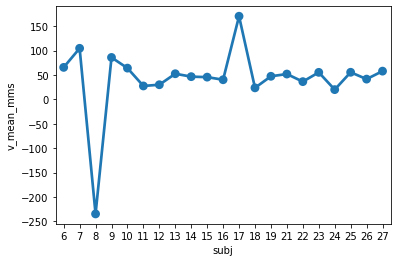

In [ ]:
v_mean_by_subject = filtered_df.groupby(['subj'])['v_mean_mms'].mean()   # v_mean() for each subject
sns.pointplot(data=v_mean_by_subject.reset_index(), x='subj',y='v_mean_mms')

In [30]:
# locate rows with not a standard v_mean
v_filter = (filtered_df['v_mean_mms'] > 300) |  (filtered_df['v_mean_mms'] < 0)
filtered_df[v_filter] 

,date_yymmdd,hour_h,minute_min,subj,block,trial,texture,start_s,end_s,sliding_distance_mm,v_mean_mms,fn_mean_n,fn_std_n,ft_mean_n,ft_std_n,cof_mean,cof_std,rms_accelero_ms
83,221122,8,42,16,3,0,1,0.2680,0.4612,-189.179291,-406.446715,-0.001045,0.009138,-0.000201,0.000866,0.024723,1.524940,0.597579
84,221122,8,42,16,3,0,2,0.8334,1.0054,-42.073049,-759.093773,-0.001654,0.008313,-0.000204,0.000550,0.028285,1.723719,1.089030
129,221122,8,42,16,4,0,1,0.3510,0.6732,128.008126,-102.126788,-0.000891,0.011209,-0.000113,0.001044,0.099480,2.912515,0.472312
231,221122,10,23,17,1,16,1,0.3462,0.3812,24.990426,1471.152509,0.003755,0.007496,-0.004445,0.001858,-1.185046,5.601719,0.125029
232,221122,10,23,17,1,16,2,0.4854,0.5008,142.611718,13463.971511,-0.003674,0.005389,-0.008271,0.001098,2.566126,14.246778,0.123659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2808,221110,8,22,6,1,2,2,3.7298,4.0166,-1.209241,-1.427792,0.528894,0.041373,0.492902,0.038785,0.941459,0.131747,0.270764
2810,221110,8,22,6,1,3,2,4.0290,4.3712,-1.223049,-1.898012,0.687975,0.113679,0.073072,0.093514,0.084463,0.147489,0.036058
2846,221110,8,22,6,2,2,2,5.3024,5.5668,-86.464887,3822.601132,0.000521,0.007273,-0.000127,0.001059,0.816711,27.645549,0.370926
2856,221110,8,22,6,2,7,2,4.5780,4.7136,-6.499239,1324.218499,0.398860,0.309992,0.014210,0.054666,-0.351170,13.392552,2.367558


In [31]:
# A new dataframe with only standard v_mean
df_adjusted_v_mean = filtered_df[~v_filter] 

<AxesSubplot:xlabel='subj', ylabel='v_mean_mms'>

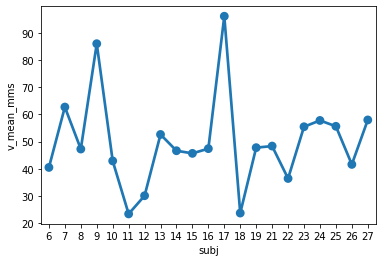

In [32]:
v_mean_std_by_subject = df_adjusted_v_mean.groupby(['subj'])['v_mean_mms'].mean()   # v_mean() for each subject
sns.pointplot(data=v_mean_std_by_subject.reset_index(), x='subj',y='v_mean_mms')

### Subjects with high fn_mean

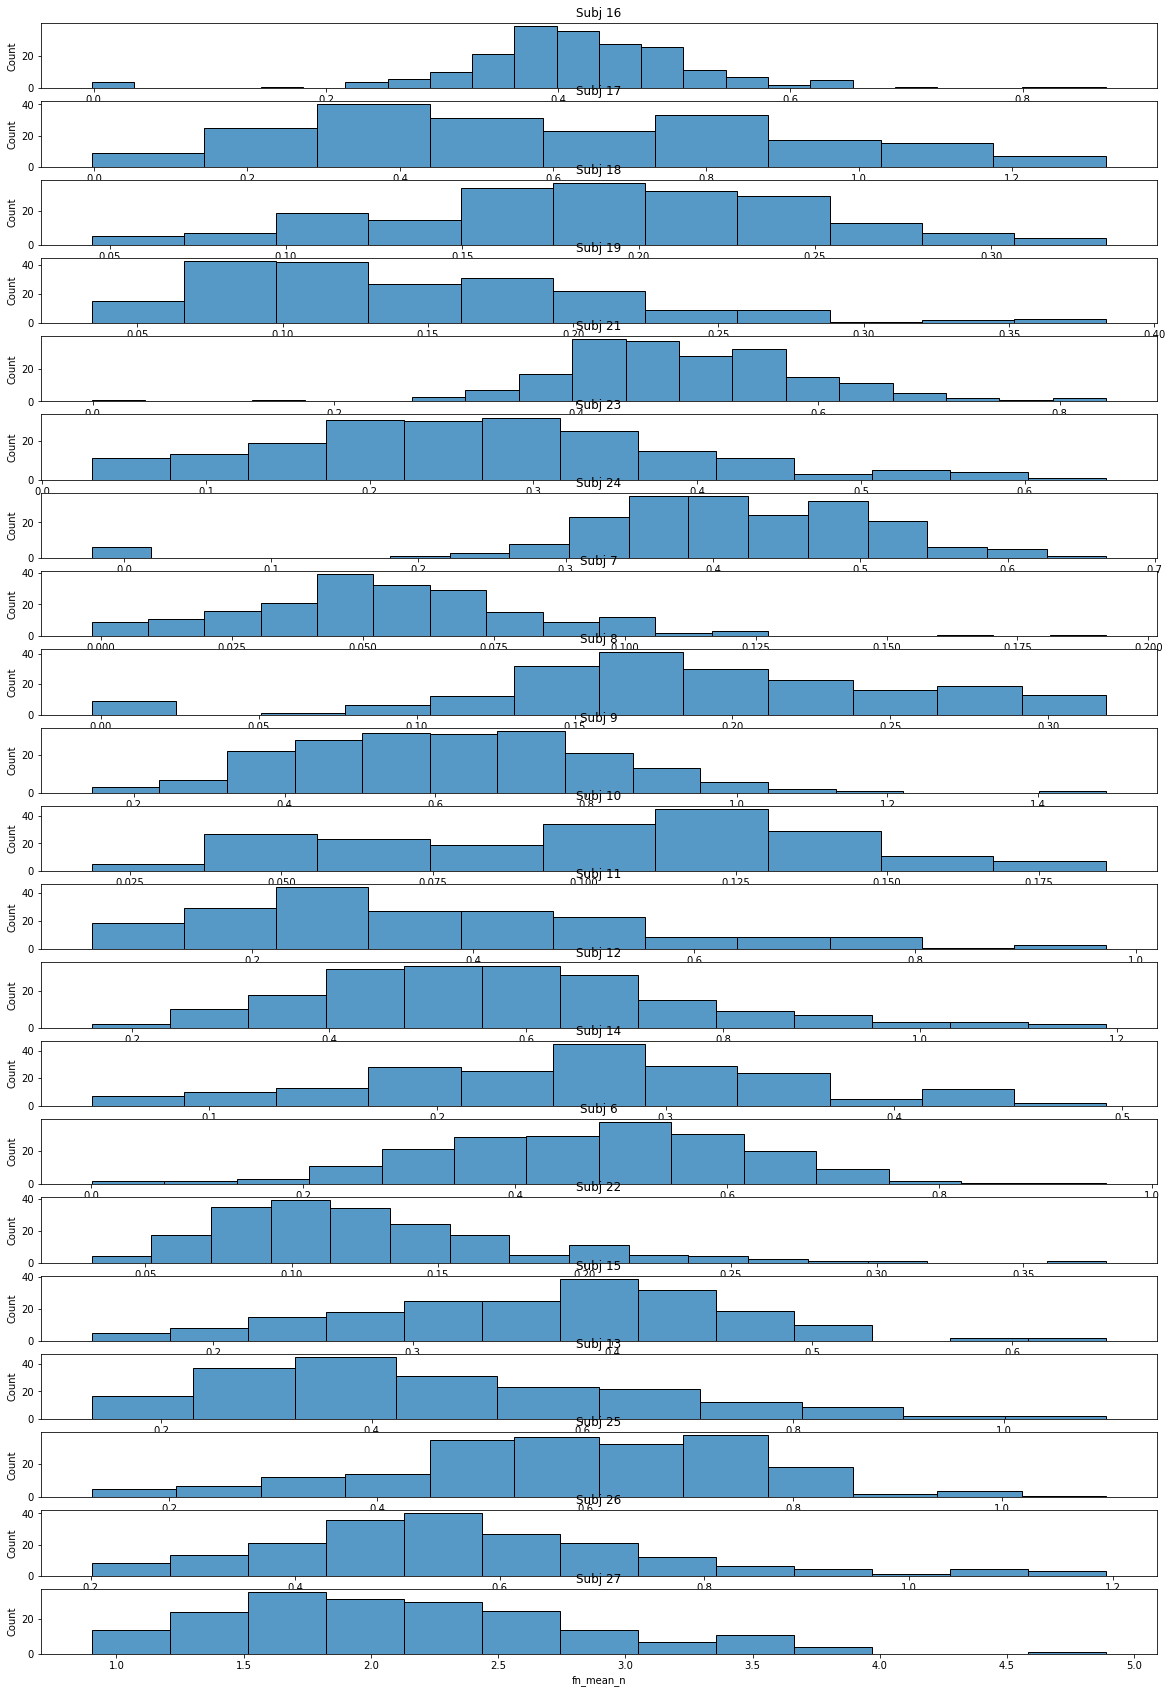

In [33]:
subjs = filtered_df.subj.unique()
plt.subplots(figsize=(20,30))
for ind, subj in enumerate(subjs): 
    plt.subplot(filtered_df.subj.nunique(),1,ind+1)
    sns.histplot(data=filtered_df[filtered_df.subj==subj],
                 x='fn_mean_n', label='%s'%subj)
    plt.title('Subj %s'%subj)
    


<AxesSubplot:xlabel='subj', ylabel='fn_mean_n'>

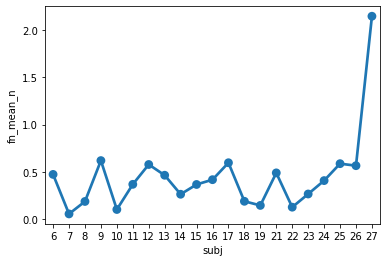

In [34]:
fn_mean_std_by_subject = filtered_df.groupby(['subj'])['fn_mean_n'].mean()   # fn_mean() for each subject
sns.pointplot(data=fn_mean_std_by_subject.reset_index(), x='subj',y='fn_mean_n')

In [ ]:
df_adjusted_v_mean.to_csv('data/meca/all_data.csv')

In [ ]:
df_2.iloc[:, df_2.columns.get_loc("sliding_distance_mm"):df_2.columns.get_loc("rms_accelero_ms")].describe()


,sliding_distance_mm,v_mean_mms,fn_mean_n,fn_std_n,ft_mean_n,ft_std_n,cof_mean,cof_std
count,4165.000000,4165.000000,4165.000000,4165.000000,4165.000000,4165.000000,4165.000000,4165.000000
mean,26.295689,42.070258,0.445689,0.037563,0.347754,0.036855,1.339451,12.048311
std,321.747076,1064.212070,0.463743,0.036777,0.284834,0.034651,5.246235,259.741326
min,-19560.044934,-65254.684509,-0.021901,0.005389,-0.069379,0.000223,-269.963031,0.000503
25%,28.149613,34.463600,0.177759,0.018697,0.161056,0.014210,0.451177,0.027641
50%,33.437954,45.909203,0.358537,0.027268,0.269227,0.026139,0.674279,0.060533
75%,38.596190,57.868461,0.534343,0.043440,0.429359,0.047171,1.234040,0.182988
max,1026.170755,13463.971511,4.890003,0.591267,2.159151,0.425295,93.620329,14313.955103


In [ ]:
df_2.to_csv('data/meca/meca.csv')

### Join les deux dataframes

In [39]:
data_df['stim_order'] = data_df['stim_order'].apply(lambda x: x+1)

<ipython-input-39-bd217c25a9fc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['stim_order'] = data_df['stim_order'].apply(lambda x: x+1)


In [38]:
df_2.rename(columns={'texture': 'stim_order'}, inplace=True)

In [40]:
df_result = pd.merge(data_df, df_2, on=['subj', 'trial','block','stim_order'], how='inner')

In [ ]:
pd.set_option('display.max_columns',df_result.shape[1])
df_result

,subj,trial,block,practice,condition,sex,age,date,data_file,texture_id,stim_order,diameter,opening,spacing,response,rt,date_yymmdd,hour_h,minute_min,start_s,end_s,sliding_distance_mm,v_mean_mms,fn_mean_n,fn_std_n,ft_mean_n,ft_std_n,cof_mean,cof_std,rms_accelero_ms
0,6,0,1,False,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block1_trial0.csv,E030,1,260.0,140.0,400.0,False,10.857,221110,8,22,2.4468,2.9188,27.336514,56.485055,0.101889,0.017506,0.411404,0.077333,4.112849,0.815765,4.338972
1,6,0,1,False,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block1_trial0.csv,E064,2,50.0,140.0,190.0,True,10.857,221110,8,22,3.6468,4.1268,-1.195209,0.724558,0.374153,0.047508,0.378895,0.048208,1.031406,0.201548,0.349007
2,6,1,1,False,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block1_trial1.csv,E061,1,80.0,170.0,250.0,True,11.883,221110,8,22,3.2890,3.9926,32.968886,51.992636,0.232339,0.045522,0.284906,0.026106,1.257871,0.175839,2.376460
3,6,1,1,False,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block1_trial1.csv,E006,2,260.0,20.0,280.0,False,11.883,221110,8,22,5.2008,5.5466,70.677067,238.470067,0.014616,0.043763,0.023413,0.058613,0.494322,3.759739,0.899553
4,6,2,1,False,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block1_trial2.csv,E048,1,170.0,170.0,340.0,False,10.245,221110,8,22,2.7382,3.3636,48.907967,63.353527,0.124927,0.017377,0.408266,0.052771,3.309571,0.512267,2.498284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4160,27,22,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E078(S45),2,80.0,110.0,190.0,False,8.466,221125,17,18,4.7956,5.1706,35.853592,94.943428,1.574174,0.185896,0.564810,0.082925,0.357536,0.012494,6.140435
4161,27,23,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E038,1,110.0,80.0,190.0,True,7.617,221125,17,18,2.9734,3.5476,40.110299,73.018695,1.606961,0.068391,0.926973,0.076240,0.576235,0.029874,2.816130
4162,27,23,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E076(S43),2,50.0,50.0,100.0,False,7.617,221125,17,18,5.0852,5.5312,35.825132,85.074553,1.676902,0.030933,0.750410,0.051388,0.447519,0.030270,1.416022
4163,27,24,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E044,1,170.0,140.0,310.0,True,7.534,221125,17,18,2.6174,3.2676,39.566893,60.739483,1.769655,0.085260,1.102541,0.186779,0.621689,0.096977,4.945476


### Valeurs outliers

In [ ]:
df_2['sliding_distance_mm'].describe()

count     4165.000000
mean        26.295689
std        321.747076
min     -19560.044934
25%         28.149613
50%         33.437954
75%         38.596190
max       1026.170755
Name: sliding_distance_mm, dtype: float64

In [ ]:
top_05_percent_sliding_distance = df_2[df_2['sliding_distance_mm'] >= df_2['sliding_distance_mm'].quantile(0.99)].sliding_distance_mm.min()   # minimum value of the last 1%
top_05_percent_sliding_distance


56.47166493081318

In [ ]:
top_05_percent_v_mean =  df_2[df_2['v_mean_mms'] >= df_2['v_mean_mms'].quantile(0.99)].v_mean_mms.min()   # minimum value of the last 1%
top_05_percent_v_mean

152.65619276840005

#### V_mean et sliding_distance :

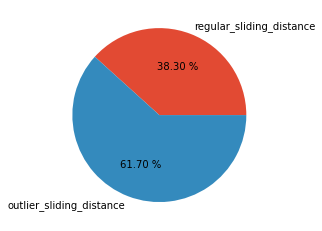

In [ ]:
n1 = ((df_2['v_mean_mms'] <0) | (df_2['v_mean_mms'] > top_05_percent_v_mean) ) & ((df_2['sliding_distance_mm'] > 0 )&( df_2['sliding_distance_mm'] < top_05_percent_sliding_distance))   # V_mean outliers with regular sliding distance
n2 = ((df_2['v_mean_mms'] <0) | (df_2['v_mean_mms'] > top_05_percent_v_mean) ) & ((df_2['sliding_distance_mm'] <0 )|( df_2['sliding_distance_mm'] > top_05_percent_sliding_distance))  # V_mean outliers with outlier sliding distance

regular_sliding_distance = df_2.loc[n1].count()[0]
outlier_sliding_distance = df_2.loc[n2].count()[0]

weights = [regular_sliding_distance, outlier_sliding_distance]
labels=  ['regular_sliding_distance','outlier_sliding_distance']
plt.pie(weights, labels = labels,autopct="%.2f %%")
plt.style.use('ggplot')

plt.show()

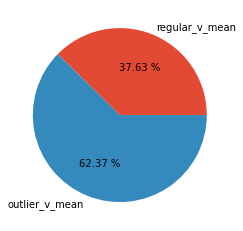

In [75]:
# sliding distance outliers with regular v_mean
m1 = ((df_2['v_mean_mms'] >0) & (df_2['v_mean_mms'] < top_05_percent_v_mean) ) & ((df_2['sliding_distance_mm'] < 0 )|( df_2['sliding_distance_mm'] > top_05_percent_sliding_distance)) 
m2 = ((df_2['v_mean_mms'] <0) | (df_2['v_mean_mms'] > top_05_percent_v_mean) ) & ((df_2['sliding_distance_mm'] <0 )|( df_2['sliding_distance_mm'] > top_05_percent_sliding_distance)) 

regular_v_mean = df_2.loc[m1].count()[0]
outlier_v_mean = df_2.loc[m2].count()[0]

weights = [regular_v_mean, outlier_v_mean]
labels=  ['regular_v_mean','outlier_v_mean']
plt.pie(weights, labels = labels,autopct="%.2f %%")
plt.style.use('ggplot')

plt.show()

In [81]:
v_mean_filter = (df_2['v_mean_mms']<top_05_percent_v_mean) &( df_2['v_mean_mms'] > 0)
df_2 = df_2.loc[v_mean_filter]

In [82]:
sliding_distance_filter = (df_2['sliding_distance_mm']<top_05_percent_sliding_distance) &( df_2['sliding_distance_mm'] > 0)
df_2 = df_2.loc[sliding_distance_filter]

<mark> Semaine 1 : </mark> 
- data loaded
- columns names changed to snake_case
- a new dataframe created (filtered_df) without subject 2 and 3
- a new dataframe created (df_adjusted_v_mean) with only standard v_mean values 
- display fn_mean by subject
- All data saved from (df_adjusted_v_mean) dataframe

<mark> TODO: 
    
    - vérifier les valeurs de v_mean etc. pour les trials duplicate    
    - si elles sont comparables, faire groupby.mean()
    - continuer de regarder les valeurs outliers sur toutes les colonnes summary (min, max, groupby.describe(), sns.hist)
    - filtrer les valeurs aberrantes
    
    - sauver dans meca_csv
    - join avec behaviour

<mark> Semaine 2 :
- localiser les trials duplicated et les regrouper dans un tableau
- filtrer les trials duplicated et remplacer leurs valeurs par leurs moyennes. (df_2)
- sauver dans meca_csv
- join avec behavious
- valeurs outliers pour v_mean et sliding_distance

## Kernel

### Kernel computation

In [ ]:
data_melt = pd.melt(data,
        id_vars=['subj','trial','block','sex','age','condition','response'],
        value_vars=['diameter','opening','spacing'],
        var_name='feature')

# z-score feature values
zscore = lambda x: (x-np.nanmean(x))/np.nanstd(x)
# zscore TAS and weights
data_melt['value'] = data_melt.groupby(['subj','feature'])['value'].transform(zscore) 

# compute difference between positives and negatives in each trial
positives = data_melt.loc[data_melt.response == True].reset_index()
negatives = data_melt.loc[data_melt.response == False].reset_index()
kernels = pd.merge(positives, negatives, on=['subj','block','trial','feature'],suffixes=['+','-'])
kernels['delta_value']=kernels['value+']-kernels['value-']

kernels.drop(['index+','response+', 'value+', 
               'index-', 'sex-', 'age-', 'condition-', 'response-', 'value-'], axis=1, inplace=True)
kernels = kernels.rename(columns={'sex+':'sex','age+':'age', 'condition+':'condition'})

# normalize for each subj by dividing by the RMS of their values over all trials 
kernels['square_delta_value'] = kernels['delta_value']**2

for_norm = kernels.groupby(['subj','condition','feature']).agg({'square_delta_value':'mean'}).reset_index()
                                          
kernels = pd.merge(kernels, for_norm, on=['subj','condition','feature'], suffixes=['','_mean'])
kernels['norm_delta_value'] = kernels['delta_value']/np.sqrt(kernels['square_delta_value_mean'])

kernels.drop(['delta_value','square_delta_value', 'square_delta_value_mean',], axis=1, inplace=True)


NameError: name 'data' is not defined

### Different kernels per condition

In [ ]:
kernels.groupby(['condition','feature']).norm_delta_value.mean()

condition  feature 
rug        diameter   -0.006298
           opening     0.613785
           spacing     0.294076
soft       diameter   -0.121706
           opening    -0.510029
           spacing    -0.342440
Name: norm_delta_value, dtype: float64

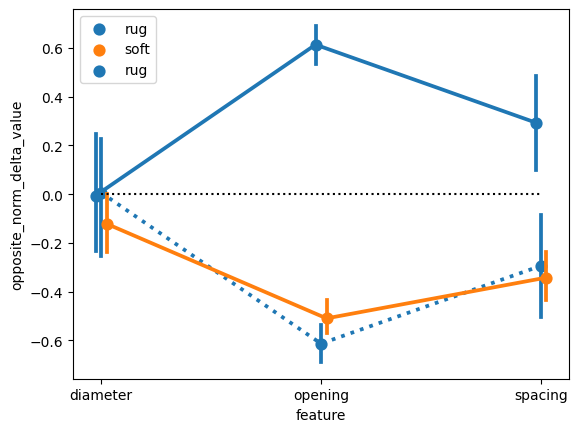

In [ ]:
sns.pointplot(data=kernels,
              hue="condition",
             x="feature",
              units='subj',
             y="norm_delta_value", dodge=True)

# plot inverse rough kernel for comparison
kernels['opposite_norm_delta_value'] = - kernels.norm_delta_value
sns.pointplot(data=kernels[kernels.condition=='rug'],
              hue="condition",
             x="feature",
              units='subj',
             y="opposite_norm_delta_value", 
              linestyles=[':'])

plt.plot([0,2],[0,0],'k:')
plt.legend(loc=2)

One-sample difference of kernel weights to zero

In [ ]:
print("One-sample difference of kernel weights to zero")
for condition in ['rug','soft']:
    print('%s:'%condition.upper())
    for feature in ['diameter','opening','spacing']: 
        
        print('- %s'%(feature))
        
        sample = kernels[(kernels.condition==condition)&
                          (kernels.feature==feature)].groupby(['subj'], as_index=False).norm_delta_value.mean()
        
        stats= pg.ttest(x=sample.norm_delta_value, y=0)
        print('t(%d)=%.2f,p=%.4f'%(stats.loc['T-test','dof'],
                               stats.loc['T-test','T'],
                               stats.loc['T-test','p-val']))

One-sample difference of kernel weights to zero
RUG:
- diameter
t(6)=-0.05,p=0.9618
- opening
t(6)=20.43,p=0.0000
- spacing
t(6)=2.70,p=0.0358
SOFT:
- diameter
t(19)=-1.97,p=0.0632
- opening
t(19)=-17.80,p=0.0000
- spacing
t(19)=-6.72,p=0.0000


Two-sample difference of kernel weights between soft and non-rough

In [ ]:
print("Two-sample difference of kernel weights between soft and non-rough")
for feature in ['diameter','opening','spacing']: 
    print('- %s'%(feature))
      
    sample_soft = kernels[(kernels.condition=='soft')&
                          (kernels.feature==feature)].groupby(['subj'], as_index=False).norm_delta_value.mean()

    sample_rug = kernels[(kernels.condition=='rug')&
                          (kernels.feature==feature)].groupby(['subj'], as_index=False).norm_delta_value.mean()
    
    stats= pg.ttest(x=sample_soft.norm_delta_value, 
                    y=-sample_rug.norm_delta_value)
    
    print('t(%d)=%.2f,p=%.4f'%(stats.loc['T-test','dof'],
                               stats.loc['T-test','T'],
                               stats.loc['T-test','p-val']))

Two-sample difference of kernel weights between soft and non-rough
- diameter
t(9)=-0.91,p=0.3853
- opening
t(17)=2.50,p=0.0228
- spacing
t(8)=-0.40,p=0.6976


### Sex difference for soft

In [ ]:
data.groupby(['condition','sex']).subj.nunique()

condition  sex
rug        f       3
           m       4
soft       f      12
           m       8
Name: subj, dtype: int64

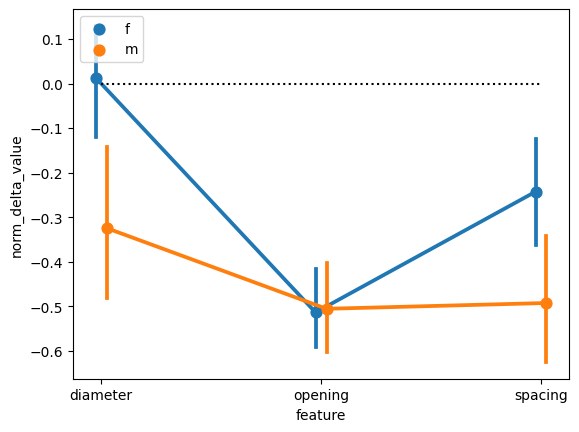

In [ ]:
sns.pointplot(data=kernels[kernels.condition=='soft'],
              hue="sex",
             x="feature",
              units='subj',
             y="norm_delta_value", dodge=True)

plt.plot([0,2],[0,0],'k:')
plt.legend(loc=2)

In [ ]:
print("Two-sample difference of kernel weights between male and female soft")
for feature in ['diameter','opening','spacing']: 
    print('- %s'%(feature))
      
    sample_male = kernels[(kernels.condition=='soft')&
                          (kernels.sex=='m')&
                          (kernels.feature==feature)].groupby(['subj'], as_index=False).norm_delta_value.mean()

    sample_female = kernels[(kernels.condition=='soft')&
                          (kernels.sex=='f')&
                          (kernels.feature==feature)].groupby(['subj'], as_index=False).norm_delta_value.mean()
    
    stats= pg.ttest(x=sample_male.norm_delta_value, 
                    y=sample_female.norm_delta_value)
    
    print('t(%d)=%.2f,p=%.4f'%(stats.loc['T-test','dof'],
                               stats.loc['T-test','T'],
                               stats.loc['T-test','p-val']))

Two-sample difference of kernel weights between male and female soft
- diameter
t(13)=-3.17,p=0.0073
- opening
t(15)=0.14,p=0.8934
- spacing
t(14)=-2.77,p=0.0145


Remember that the first few participants (3 ?) had a bug that resulted in not stopping the recording at the time of response

(-0.01, 0.05)

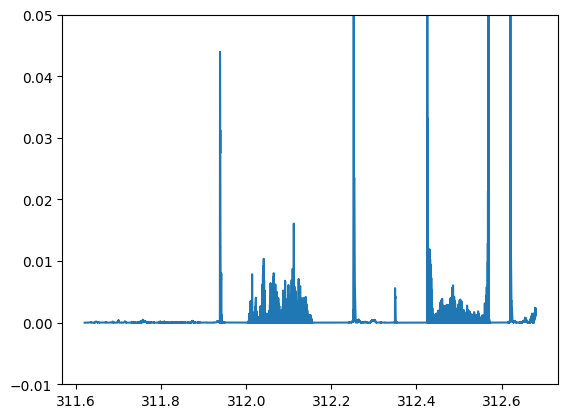